In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cosmodc2 as extract_cosmodc2
import lens_data as lens
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
from mysql.connector import Error
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

# Lens catalog

## Cosmodc2 with qserv & GCRCatalogs

In [3]:
#z, ra, dec = lens_catalog['redshift'][index], lens_catalog['ra'][index], lens_catalog['dec'][index]
z, ra, dec = .2, 65, -40

### true shapes, true redshifts

# DC2

In [36]:
%load_ext autoreload
%autoreload 2
import dc2
from GCR import GCRQuery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
tract_list = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/data_extraction/tract_dc2dr6_coord.pkl')

In [38]:
z, ra, dec = 0.1, 65, -40

In [39]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')

In [49]:
def filters(zmin):
    r""" redshift + quality filters"""
    resolution_min = 0.2
    err_shape_max = 0.4
    
    object_basic_cuts = [
        GCRQuery('extendedness > 0'),     # Extended objects
        GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
        GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Error code returned by shape measurement code
        GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')),] # Shape measurement uncertainty should not be NaN
    object_properties_cuts = [
        GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
        GCRQuery('mag_i_cModel < 25'),                                 # cModel imag brighter than 24.5
        GCRQuery(f'ext_shapeHSM_HsmShapeRegauss_resolution >= {resolution_min}'), # Sufficiently resolved galaxies compared to PSF
        GCRQuery(f'ext_shapeHSM_HsmShapeRegauss_sigma <= {err_shape_max}'), 
        # New cut on blendedness:
        GCRQuery('blendedness < 10**(-0.375)'),                      # Avoid spurious detections and those contaminated by blends
        GCRQuery(f'photoz_mean > {zmin}'),
        #GCRQuery(f'photoz_mean < {zmax}')
        ]
    return  object_basic_cuts + object_properties_cuts

#quantities
def quantities():
    r"""quantities wanted"""
    quantity_label = ['id', 'ra', 'dec', 'mag_i_cModel','snr_i_cModel', 'mag_i']
    quantity_wanted_HSM_Metacal = ['ext_shapeHSM_HsmShapeRegauss_e2',
                           'ext_shapeHSM_HsmShapeRegauss_e1',
                           'ext_shapeHSM_HsmShapeRegauss_sigma', 
                           'ext_shapeHSM_HsmShapeRegauss_resolution',]
                         # 'mcal_g1', 'mcal_g2', 'mcal_gauss_g1','mcal_gauss_g1', 'mcal_psf_g1', 'mcal_psf_g2']
    quantity_wanted_photozs = ['photoz_mean', 'photoz_pdf','photoz_odds']
    return  quantity_label + quantity_wanted_HSM_Metacal + quantity_wanted_photozs

In [50]:
rmax=5

In [51]:
cl=dc2.extract(lens_redshift=z, lens_ra=ra, lens_dec=dec, rmax=rmax, cosmo=cosmo, 
               GCRcatalog=object_cat, data_filters=filters(z), quantities=quantities())

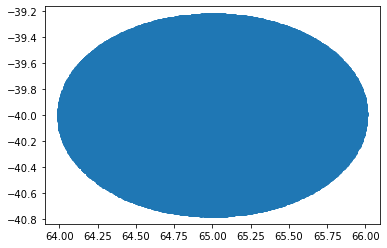

In [52]:
plt.scatter(cl.galcat['ra'], cl.galcat['dec'])

##### 

In [53]:
theta_arcmin = 3437.75*(rmax/cosmo.eval_da_z1z2(0, z))

In [54]:
S_arcmin2 =np.pi*theta_arcmin**2

In [55]:
mag_i_list = np.linspace(24, 28, 10)

In [56]:
snr = np.linspace(0, 30, 30)

In [57]:
masks=[cl.galcat['snr_i_cModel'] > i for i in snr]

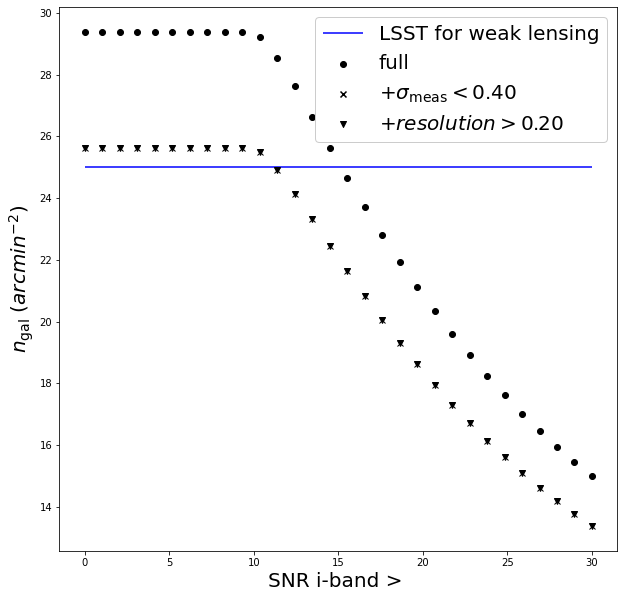

In [58]:
plt.figure(figsize=(10,10))
plt.hlines(25, 0, 30, color='b', label='LSST for weak lensing')
for i,mask in enumerate(masks):
    n_gal_arcmin2=len(cl.galcat[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'o', color='k')
    #redshift window
    res_min = .2
    err_meas_max = .4
    mask = mask * ( cl.galcat['photoz_mean'] <= 1.4)*( cl.galcat['photoz_mean'] >= .2)
    #shape measurement error
    mask = mask *( cl.galcat['ext_shapeHSM_HsmShapeRegauss_sigma'] <= err_meas_max)#label = f'{n_gal_arcmin2}')
    n_gal_arcmin2=len(cl.galcat[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'x', color='k')
    #resolution
    mask = mask *( cl.galcat['ext_shapeHSM_HsmShapeRegauss_resolution'] >= res_min)#label = f'{n_gal_arcmin2}')
    n_gal_arcmin2=len(cl.galcat[mask])/S_arcmin2
    plt.plot(snr[i], n_gal_arcmin2 ,'v',  color='k')
plt.scatter([],[], marker='o', label='full', c='k')
plt.scatter([],[], marker='x', label=r'$+\sigma_{\rm meas} <$'+ f'{err_meas_max:.2f}',c='k')
plt.scatter([],[], marker='v', label=r'$+ resolution >$'+ f'{res_min:.2f}', c='k')
plt.xlabel(r'SNR i-band > ', fontsize=20)
plt.ylabel(r'$n_{\rm gal}$ $(arcmin^{-2})$', fontsize=20)
plt.legend(framealpha=1, fontsize=20)